# Model mass generation

In [2]:
import openseespy.opensees as ops
import opstool as opst

## Line and area elements

First create several beam elements and a shell element:

In [3]:
ops.wipe()
ops.model("basic", "-ndm", 3, "-ndf", 6)
ops.node(1, 0, 0, 0)
ops.node(2, 0, 0, 1)
ops.node(3, 2, 0, 1)
ops.node(4, 2, 0, 0)
ops.node(5, 0, 0, 2)
ops.node(6, 2, 0, 2)

ops.fix(1, 1, 1, 1, 1, 1, 1)
ops.fix(4, 1, 1, 1, 1, 1, 1)

ops.geomTransf("Linear", 1, -1, 0, 0)
beam_area = 1
ops.element("elasticBeamColumn", 1, *[1, 2], beam_area, 1, 1, 1, 1, 1, 1)
ops.element("elasticBeamColumn", 2, *[4, 3], beam_area, 1, 1, 1, 1, 1, 1)

ops.nDMaterial("ElasticIsotropic", 1, 1000.0, 0.2)
ops.section("LayeredShell", 11, 4, 1, 0.025, 1, 0.025, 1, 0.025, 1, 0.025)

# create the shell element using the small displacements/rotations assumption
ops.element("ASDShellQ4", 3, *[2, 3, 6, 5], 11)

Using ASDShellQ4 - Developed by: Massimo Petracca, Guido Camata, ASDEA Software Technology


OPSTOOL ::  Model data has been saved to _OPSTOOL_ODB/ModelData-None.nc!

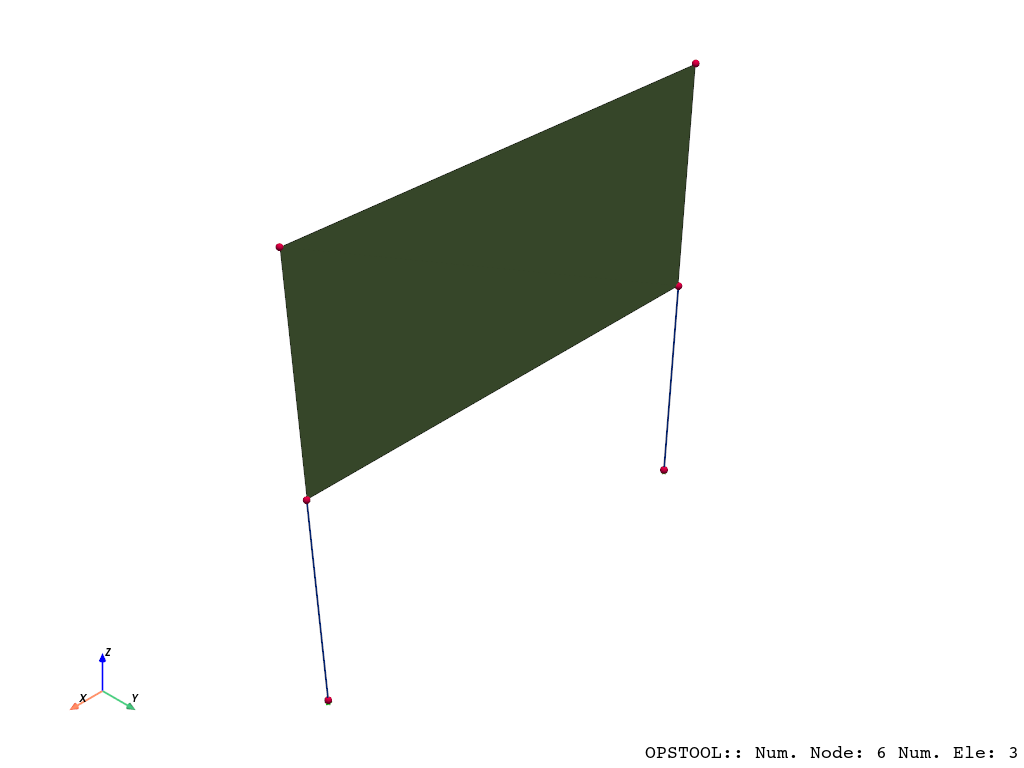

In [4]:
opst.vis.pyvista.set_plot_props(notebook=True, point_size=8)
opst.vis.pyvista.plot_model().show(jupyter_backend="jupyterlab")


Creating masses for these elements is quite simple: you only need to provide the mass density and the cross-sectional area for beam elements or the thickness for shell elements. The system will automatically calculate the volume of beam elements and distribute the mass evenly across the nodes.

In [5]:
MODEL_MASS = opst.pre.ModelMass()
MODEL_MASS.add_mass_from_line(ele_tags=[1, 2], rho=1, area=1)
MODEL_MASS.add_mass_from_surf(ele_tags=[3], rho=1, d=0.1)
nodel_mass = MODEL_MASS.get_node_mass()
nodel_mass

{1: 0.5, 2: 0.55, 4: 0.5, 3: 0.55, 6: 0.05, 5: 0.05}

We can verify the correctness of these results. For example:

Beam: 1×1×1=1

Shell: 1×2×0.1=0.2

Thus, the mass distributed to each node is as follows:

Node 1: 1 / 2 = 0.5

Node 2: 0.5+0.2/4=0.55

Node 3: 0.55

Node 4: 0.5

Node 5: 0.05

Node 6: 0.05

Generate OpenSeesPy Node Mass Commands

In [6]:
MODEL_MASS.generate_ops_node_mass()

Automatically Generate Gravity Loads:

In [7]:
ops.timeSeries("Linear", 1)
ops.pattern("Plain", 1, 1)
MODEL_MASS.generate_ops_gravity_load(direction="Z", factor=-9.81)

## Solid element

In [8]:
ops.wipe()
ops.model("basic", "-ndm", 3, "-ndf", 3)
ops.nDMaterial("ElasticIsotropic", 1, 1000.0, 0.2)

ops.node(1, 0, 0, 0)
ops.node(2, 1, 0, 0)
ops.node(3, 1, 1, 0)
ops.node(4, 0, 1, 0)
ops.node(5, 0, 0, 1)
ops.node(6, 1, 0, 1)
ops.node(7, 1, 1, 1)
ops.node(8, 0, 1, 1)

ops.element("stdBrick", 1, *[1, 2, 3, 4, 5, 6, 7, 8], 1)

OPSTOOL ::  Model data has been saved to _OPSTOOL_ODB/ModelData-None.nc!

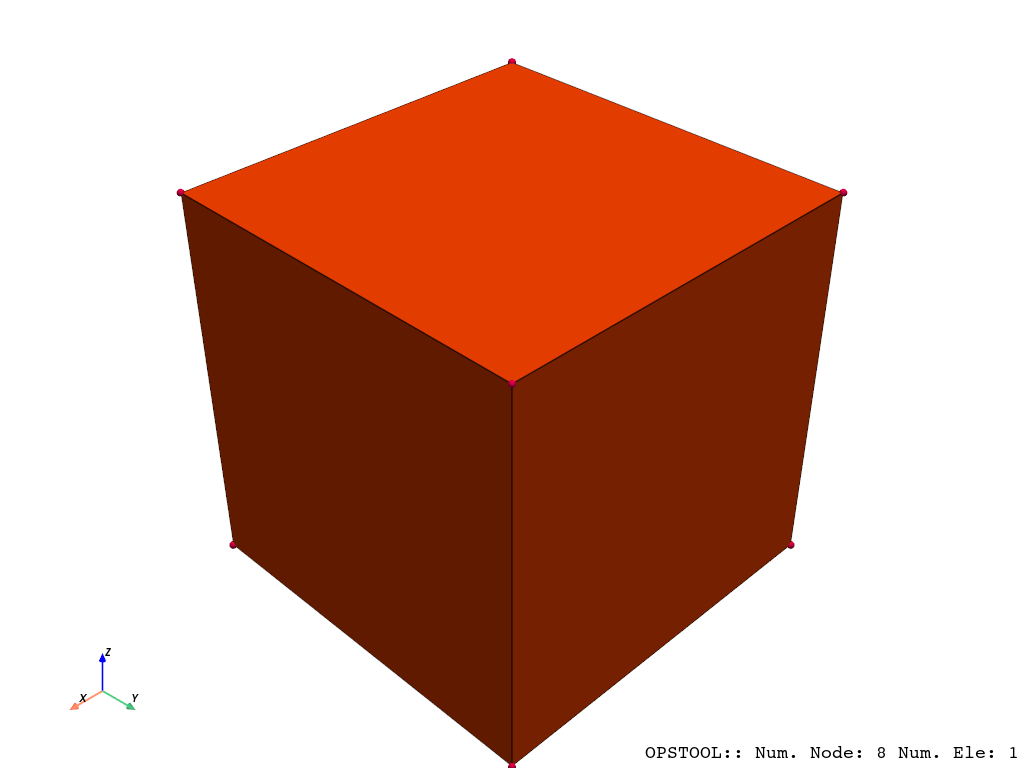

In [9]:
opst.vis.pyvista.set_plot_props(notebook=True, point_size=8)
opst.vis.pyvista.plot_model().show(jupyter_backend="jupyterlab")

In [10]:
MODEL_MASS = opst.pre.ModelMass()
MODEL_MASS.add_mass_from_brick(ele_tags=[1], rho=1)
nodel_mass = MODEL_MASS.get_node_mass()
nodel_mass

{1: 0.125,
 2: 0.125,
 3: 0.125,
 4: 0.125,
 5: 0.125,
 6: 0.125,
 7: 0.125,
 8: 0.125}

Exactly, consistent with our expected 1/8.